In [1]:
import os
import kagglehub
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download latest version
path = kagglehub.dataset_download("stkbailey/nashville-meetup")

print("Path to dataset files:", path)

archivos = os.listdir(path)

for archivo in archivos:
    print(archivo)

Path to dataset files: C:\Users\marco\.cache\kagglehub\datasets\stkbailey\nashville-meetup\versions\5
group-edges.csv
member-edges.csv
member-to-group-edges.csv
meta-events.csv
meta-groups.csv
meta-members.csv
rsvps.csv


In [3]:
# Define las variables de la descarga anterior
path = kagglehub.dataset_download("stkbailey/nashville-meetup")
archivos = os.listdir(path)

# Creamos el diccionario para guardar los DataFrames
dataframes = {} 

print("--- Cargando Archivos ---")

for archivo in archivos:

    df = pd.read_csv(os.path.join(path, archivo))
    
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
         
    nombre_clave = archivo.replace(".csv", "")

    dataframes[nombre_clave] = df
                
    print(f"✅ Cargado: {nombre_clave}")
    print("-" * 20)

print("--- Carga Completa ---")
print(f"Diccionario de DataFrames creado con las siguientes claves: {dataframes.keys()}")

--- Cargando Archivos ---
✅ Cargado: group-edges
--------------------
✅ Cargado: member-edges
--------------------
✅ Cargado: member-to-group-edges
--------------------
✅ Cargado: meta-events
--------------------
✅ Cargado: meta-groups
--------------------
✅ Cargado: meta-members
--------------------
✅ Cargado: rsvps
--------------------
--- Carga Completa ---
Diccionario de DataFrames creado con las siguientes claves: dict_keys(['group-edges', 'member-edges', 'member-to-group-edges', 'meta-events', 'meta-groups', 'meta-members', 'rsvps'])


In [4]:
for col in dataframes.keys():
    print(col)
    print(dataframes[col].shape)
    
    print(dataframes[col].columns)
    print("-" * 20)

group-edges
(6692, 3)
Index(['group1', 'group2', 'weight'], dtype='object')
--------------------
member-edges
(1176368, 3)
Index(['member1', 'member2', 'weight'], dtype='object')
--------------------
member-to-group-edges
(45583, 3)
Index(['member_id', 'group_id', 'weight'], dtype='object')
--------------------
meta-events
(19307, 4)
Index(['event_id', 'group_id', 'name', 'time'], dtype='object')
--------------------
meta-groups
(602, 7)
Index(['group_id', 'group_name', 'num_members', 'category_id', 'category_name',
       'organizer_id', 'group_urlname'],
      dtype='object')
--------------------
meta-members
(24591, 7)
Index(['member_id', 'name', 'hometown', 'city', 'state', 'lat', 'lon'], dtype='object')
--------------------
rsvps
(126813, 3)
Index(['event_id', 'member_id', 'group_id'], dtype='object')
--------------------


In [30]:
group_edges=dataframes['group-edges'].copy()
member_edges=dataframes['member-edges'].copy()
member_to_group_edges=dataframes['member-to-group-edges'].copy()
meta_events=dataframes['meta-events'].copy()
meta_groups=dataframes['meta-groups'].copy()
meta_members=dataframes['meta-members'].copy()
rsvps=dataframes['rsvps'].copy()

La idea es detectar anomalías en un grafo, por lo que los CSV `group-edges`, `member-edges` y `member-to-group-edges`, que podrían considerarse grafos separados, se unificarán en un solo grafo.

Para hacerlo, es necesario asegurarse de que los nodos compartidos entre `group-edges` y `member-to-group-edges`, así como entre `member-edges` y `member-to-group-edges`, coincidan tanto en cantidad como en identidad.

Esto es importante porque:

- Evita nodos “huérfanos”: si un nodo aparece en `member-to-group-edges` pero no en `member-edges` o `group-edges`, quedaría aislado o sin relaciones completas, lo que podría distorsionar los embeddings y afectar la detección de anomalías.

- Garantiza consistencia del grafo: al combinar los grafos, cada nodo debería tener todas sus conexiones válidas. Nodos que no existen en los grafos base pueden generar errores o falsos positivos en modelos como GAE o DOMINANT, porque el modelo intentaría reconstruir relaciones que en realidad no existen.

In [31]:
# Conjuntos de miembros y grupos
members_mtg = set(member_to_group_edges['member_id'].unique())
members_mm  = set(member_edges['member1']).union(set(member_edges['member2']))

groups_mtg = set(member_to_group_edges['group_id'].unique())
groups_gg  = set(group_edges['group1']).union(set(group_edges['group2']))

# Imprimir resultados
print(len(members_mm), "miembros aparecen en el grafo member-member")
print(len(members_mtg), "miembros aparecen en el grafo member-to-group\n")
print(len(groups_gg), "grupos aparecen en el grafo group-group")
print(len(groups_mtg), "grupos aparecen en el grafo member-to-group")


11372 miembros aparecen en el grafo member-member
24631 miembros aparecen en el grafo member-to-group

456 grupos aparecen en el grafo group-group
602 grupos aparecen en el grafo member-to-group


In [32]:
# Conjuntos válidos de nodos
valid_members = set(member_edges['member1']).union(set(member_edges['member2']))
valid_groups  = set(group_edges['group1']).union(set(group_edges['group2']))

# Filtrar member_to_group_edges
member_to_group_edges = member_to_group_edges[
    member_to_group_edges['member_id'].isin(valid_members) &
    member_to_group_edges['group_id'].isin(valid_groups)
].copy()

# Ver cuántos quedan
print("Tras el filtrado tenemos los", len(set(member_to_group_edges['group_id'].unique())), "grupos y", len(set(member_to_group_edges['member_id'].unique())), "miembros en el grafo member-to-group,")
print("pasando de", len(member_to_group_edges), "a", len(member_to_group_edges), "filas")


Tras el filtrado tenemos los 456 grupos y 11372 miembros en el grafo member-to-group,
pasando de 28608 a 28608 filas


In [66]:
dataframes_dict = {
    "group_edges": group_edges,
    "member_edges": member_edges,
    "member_to_group_edges": member_to_group_edges,
    "meta_groups": meta_groups,
    "meta_members": meta_members,
}

for name, df in dataframes_dict.items():
    total_nulls = df.isna().sum().sum()  # Suma primero por columna y luego todo junto
    print(f"{name} - Total de valores nulos: {total_nulls}")
    print("-" * 40)

group_edges - Total de valores nulos: 0
----------------------------------------
member_edges - Total de valores nulos: 0
----------------------------------------
member_to_group_edges - Total de valores nulos: 0
----------------------------------------
meta_groups - Total de valores nulos: 0
----------------------------------------
meta_members - Total de valores nulos: 19758
----------------------------------------


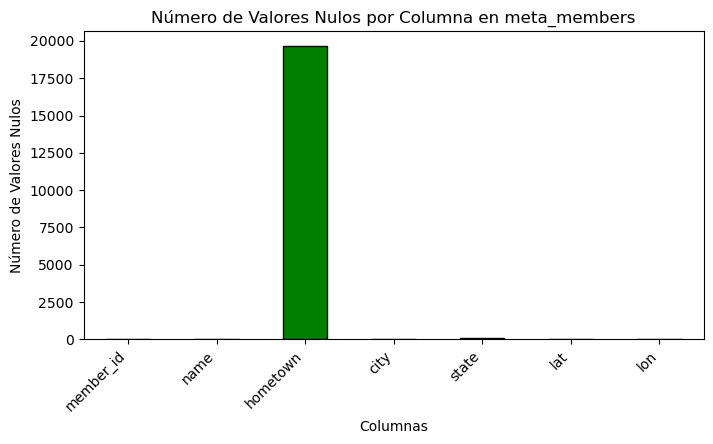

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))

meta_members.isna().sum().plot(kind='bar', ax=ax, color='green', edgecolor='black')

ax.set_title("Número de Valores Nulos por Columna en meta_members")
ax.set_xlabel("Columnas")
ax.set_ylabel("Número de Valores Nulos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


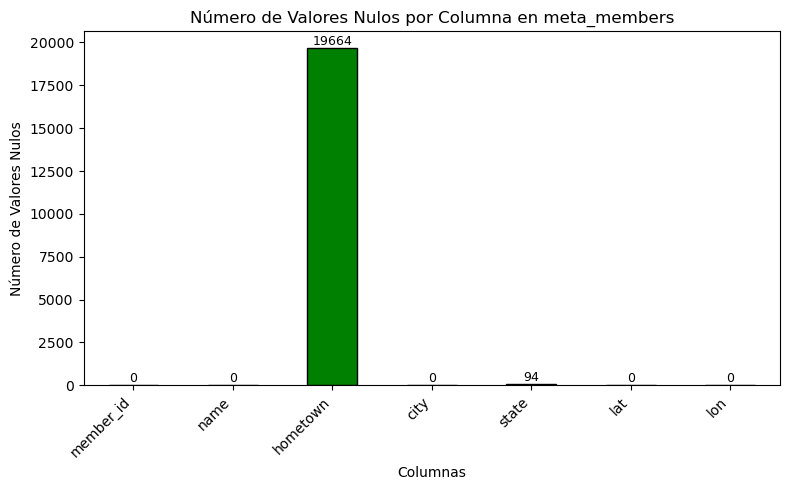

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Número de valores nulos por columna
null_counts = meta_members.isna().sum()

# Crear gráfico de barras
null_counts.plot(kind='bar', ax=ax, color='green', edgecolor='black')

# Añadir etiquetas encima de cada barra mostrando la proporción
for i, val in enumerate(null_counts):
    ax.text(i, val + 0.5, f'{val}', ha='center', va='bottom', fontsize=9)

ax.set_title("Número de Valores Nulos por Columna en meta_members")
ax.set_xlabel("Columnas")
ax.set_ylabel("Número de Valores Nulos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [71]:
meta_members.isna().sum().shape

(7,)